# Lookalike Customer Recommendation Engine
To build a Lookalike Model that recommends similar customers based on their profiles and transaction history, we can follow a structured approach. The sample high level approach could be as follows:

* Step 1: Data Preparation
    * Load the Data: Read the Customers.csv file to get customer and transaction data.
    * Data Cleaning: Handle missing values, duplicates, and ensure data types are correct.
    * Feature Engineering: Create features that represent customer profiles and transaction history.

* Step 2: Define Similarity Metrics
    * Customer Profile Features: Use demographic information (age, gender, location, etc.).
    * Transaction History Features: Use transaction frequency, average transaction value, and product categories purchased.
    * Similarity Calculation: Use a distance metric (e.g., cosine similarity, Euclidean distance) to calculate similarity scores between customers.

* Step 3: Build the Lookalike Model
    * Calculate Similarity Scores: For each customer, calculate similarity scores with all other customers.
    * Select Top 3 Lookalikes: For each customer, select the top 3 customers with the highest similarity scores.

* Step 4: Output the Results
    * Create Lookalike.csv: Store the results in the specified format.


In [3]:
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [2]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
# Step 1: Load the Data
customers = pd.read_csv('Customers.csv')

# Step 2: Data Cleaning
# Drop rows with missing values
customers.dropna(inplace=True)

In [4]:
# Step 3: Feature Engineering
# Create a feature matrix excluding non-numeric features
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['DaysSinceSignup'] = (pd.Timestamp.now() - customers['SignupDate']).dt.days

# Select relevant features for similarity
features = customers[['DaysSinceSignup', 'Region']]  # Add more features as needed
features = pd.get_dummies(features)  # Convert categorical variables to dummy variables

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [18]:
# Step 4: Calculate Similarity Scores
similarity_matrix = cosine_similarity(features_scaled)

In [6]:
# Step 5: Get Top 3 Lookalikes
lookalikes = {}
for i in range(len(customers)):
    similar_indices = similarity_matrix[i].argsort()[-4:-1][::-1]  # Get top 3 excluding self
    similar_customers = [(customers.iloc[j]['CustomerID'], similarity_matrix[i][j]) for j in similar_indices]
    lookalikes[customers.iloc[i]['CustomerID']] = similar_customers

In [7]:
# Step 6: Create Lookalike.csv
# Prepare the DataFrame in the required format
lookalike_records = []
for cust_id, similar in lookalikes.items():
    for similar_cust_id, score in similar:
        lookalike_records.append({'CustomerID': cust_id, 'LookalikeID': similar_cust_id, 'Score': score})

lookalike_df = pd.DataFrame(lookalike_records)
lookalike_df.to_csv('Lookalike.csv', index=False)

In [8]:
lookalike_df.head()

,CustomerID,LookalikeID,Score
0,C0001,C0112,0.999993
1,C0001,C0025,0.999974
2,C0001,C0071,0.999942
3,C0002,C0134,0.999985
4,C0002,C0045,0.999938


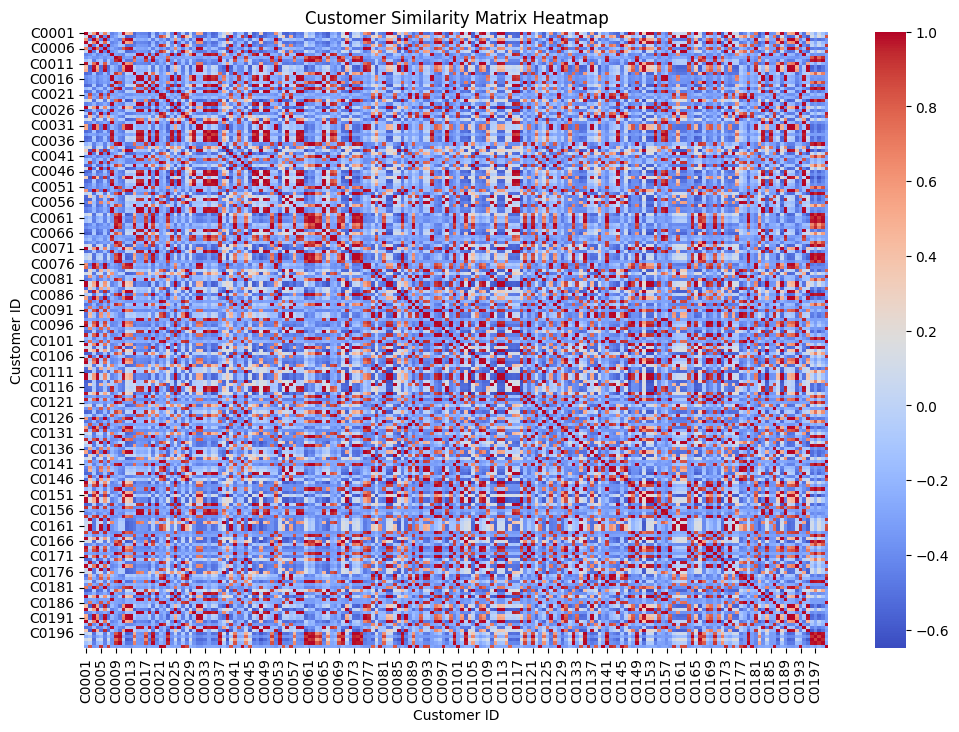

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

similarity_matrix = pd.DataFrame(similarity_matrix, index=customers['CustomerID'], columns=customers['CustomerID'])

plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Customer Similarity Matrix Heatmap')
plt.xlabel('Customer ID')
plt.ylabel('Customer ID')
plt.show()

C:\Users\ranja\AppData\Local\Temp\ipykernel_42380\27123940.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lookalike_df['Score'], y=lookalike_df.index, palette='viridis')


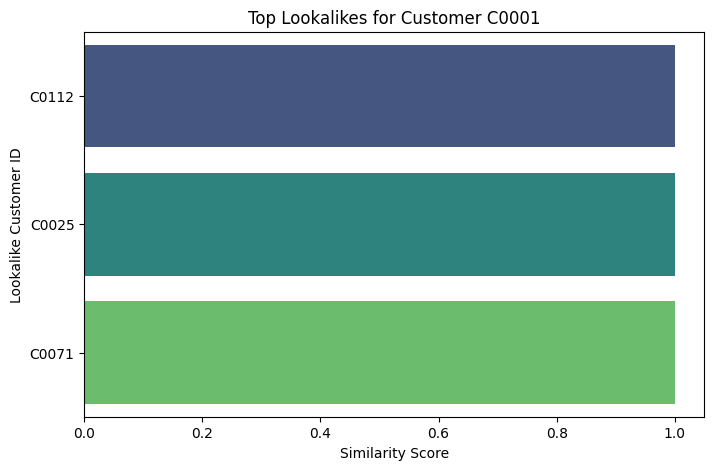

In [16]:
customer_id = 'C0001'
top_lookalikes = lookalikes[customer_id]
lookalike_df = pd.DataFrame(top_lookalikes, columns=['LookalikeID', 'Score'])
lookalike_df.set_index('LookalikeID', inplace=True)

plt.figure(figsize=(8, 5))
sns.barplot(x=lookalike_df['Score'], y=lookalike_df.index, palette='viridis')
plt.title(f'Top Lookalikes for Customer {customer_id}')
plt.xlabel('Similarity Score')
plt.ylabel('Lookalike Customer ID')
plt.show()

In [9]:
# Optional Step: Dimensionality Reduction with PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
features_pca = pca.fit_transform(features_scaled)

In [10]:
# Clustering with K-Means
kmeans = KMeans(n_clusters=5, random_state=42)  # Choose an appropriate number of clusters
customers['Cluster'] = kmeans.fit_predict(features_pca)

c:\Users\ranja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [11]:
# Calculate Similarity Scores within Clusters
lookalikes = {}
for cluster in customers['Cluster'].unique():
    cluster_customers = customers[customers['Cluster'] == cluster]
    cluster_features = features_scaled[customers['Cluster'] == cluster]
    
    similarity_matrix = cosine_similarity(cluster_features)
    
    for i in range(len(cluster_customers)):
        similar_indices = similarity_matrix[i].argsort()[-4:-1][::-1]  # Get top 3 excluding self
        similar_customers = [(cluster_customers.iloc[j]['CustomerID'], similarity_matrix[i][j]) for j in similar_indices]
        lookalikes[cluster_customers.iloc[i]['CustomerID']] = similar_customers

In [12]:
# Step 7: Create Lookalike.csv
lookalike_records = []
for cust_id, similar in lookalikes.items():
    for similar_cust_id, score in similar:
        lookalike_records.append({'CustomerID': cust_id, 'LookalikeID': similar_cust_id, 'Score': score})

lookalike_df = pd.DataFrame(lookalike_records)
lookalike_df.to_csv('Lookalike.csv', index=False)


lookalike_df.head()

,CustomerID,LookalikeID,Score
0,C0001,C0112,0.999993
1,C0001,C0025,0.999974
2,C0001,C0071,0.999942
3,C0004,C0108,0.999887
4,C0004,C0102,0.999515


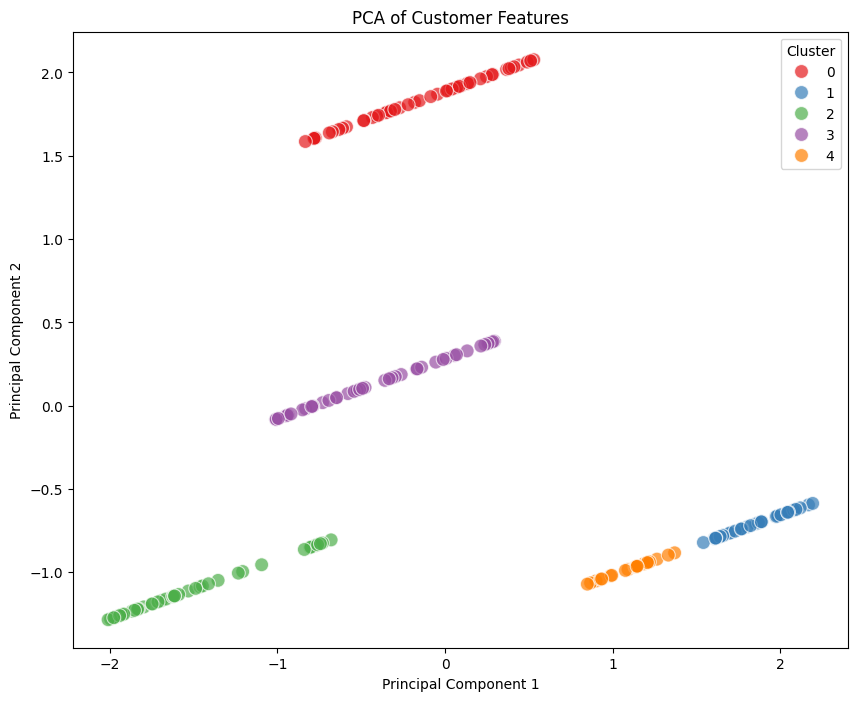

C:\Users\ranja\AppData\Local\Temp\ipykernel_42380\806293955.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pca_df, x='Cluster', palette='Set2')


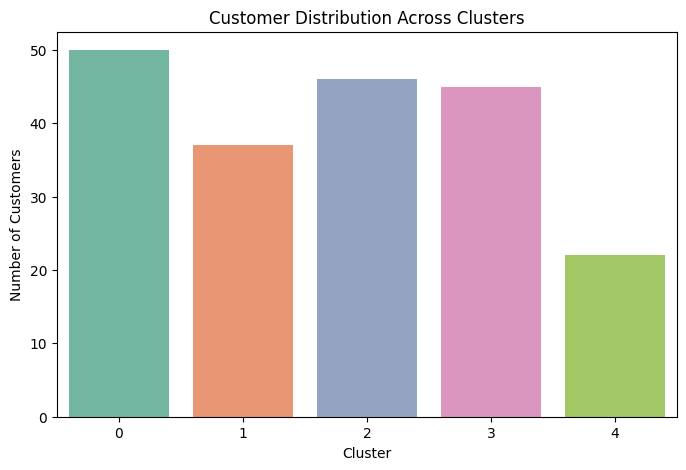

In [17]:
pca_df = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(features_pca.shape[1])])
pca_df['CustomerID'] = customers['CustomerID']
pca_df['Cluster'] = customers['Cluster']

# PCA Scatter Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', s=100, alpha=0.7)
plt.title('PCA of Customer Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Cluster Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=pca_df, x='Cluster', palette='Set2')
plt.title('Customer Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()